<a href="https://colab.research.google.com/github/mvoicer/sbpo-2020-mcdm-covid-abs/blob/main/MCDM_COVID_ABS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Criteria Decision Making For COVID-19 Public Policy Classification

Marcos A. Alves <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0001-6934-6745" href="https://orcid.org/0000-0001-6934-6745" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Petrônio C. L. Silva <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-1202-2552" href="https://orcid.org/0000-0002-1202-2552" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Paulo V. C. Batista <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0001-6165-2174" href="https://orcid.org/0000-0001-6165-2174" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Rodrigo P. Silva <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0003-2547-3835" href="https://orcid.org/0000-0003-2547-3835" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Frederico G. Guimarães <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0001-9238-8839" href="https://orcid.org/0000-0001-9238-8839" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>


<center>
<table><tr>
<td><a href="http://www.minds.eng.ufmg.br/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/minds_logo_medium.jpeg" alt="MINDS - Machine Intelligence and Data Science Lab" width="100"/></a></td>
<td><a href="#"><img src="https://avatars1.githubusercontent.com/u/54992196" alt="Grupo de Pesquisa em Ciência de Dados e Inteligência Computacional - {cidic}" width="200"/></a> </td> 
  <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
</tr>
</table>
</center>


# Libraries

In [ ]:
!pip3 install git+https://github.com/petroniocandido/COVID19_AgentBasedSimulation.git

  Cloning https://github.com/petroniocandido/COVID19_AgentBasedSimulation.git to /tmp/pip-req-build-j167xuo6
  Running command git clone -q https://github.com/petroniocandido/COVID19_AgentBasedSimulation.git /tmp/pip-req-build-j167xuo6
  Created wheel for covid-abs: filename=covid_abs-0.0.2-cp36-none-any.whl size=31401 sha256=451dfb3ee9e2f148e05a8c572033cffd11b823aca5a6b6df3421b10e22d52718
  Stored in directory: /tmp/pip-ephem-wheel-cache-y1exhoaw/wheels/2c/f2/e5/b19523185aa537b4a85e38a764488fbf9f1a0d778647925527
Successfully built covid-abs


In [ ]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import animation, rc
from IPython.display import HTML

from covid_abs.experiments import *
from covid_abs.network.graph_abs import *
from covid_abs.network.util import *
from covid_abs.util import *


# SIMULATION

## Support Functions

In [ ]:
def house_subside(house):
    if house.social_stratum <= 2 and house.environment.iteration < 1500:
        for person in house.homemates:
            if person.economical_status == EconomicalStatus.Active:
                person.environment.government.demand(person)


def business_subside(business, w):
    value = w[business.id] * .0125
    business.cash(value)
    business.environment.government.cash(-value)


def on_initialize(a, b):
    a = list()
    b = dict()


def post_initialize(x, i, a, b):
    sample_isolated(x, isolation_rate=i, list_isolated=a)

    for bus in x.business:
        b[bus.id] = bus.wealth

    b[x.government.id] = x.government.wealth
    b[x.healthcare.id] = x.healthcare.wealth



## Global Parameters

In [ ]:
global_parameters = dict(

    # General Parameters
    length=500,
    height=500,

    # Demographic
    population_size=300,
    homemates_avg=3,
    homeless_rate=0.0005,
    amplitudes={
        Status.Susceptible: 10,
        Status.Recovered_Immune: 10,
        Status.Infected: 10
    },

    # Epidemiological
    critical_limit=0.004,
    contagion_rate=.9,
    incubation_time=5,
    contagion_time=10,
    recovering_time=20,
    initial_infected_perc=.01,
    initial_immune_perc=.01,
    contagion_distance=1.,

    # Economical
    total_wealth=10000000,
    total_business=9,
    minimum_income=900.0,
    minimum_expense=600.0,
    public_gdp_share=0.1,
    business_gdp_share=0.5,
    unemployment_rate=0.12,
    business_distance=20
)


## Batch Execution of Experiments

In [ ]:
for isolation in [0]: #, .2, .4, .6, .8, 1.]:
    for masks in [True, False]:
        for subsides in [True, False]:
            isolated = list()
            wealths = dict()
            scenario = dict(**global_parameters)
            scenario['callbacks'] = {}

            # Isolation Level
            scenario['callbacks']['on_execute'] = lambda x: sleep(x)
            scenario['callbacks']['on_initialize'] = lambda x: on_initialize(isolated, wealths)
            scenario['callbacks']['post_initialize'] = lambda x: post_initialize(x, isolation, isolated, wealths)
            scenario['callbacks']['on_person_move'] = lambda x: check_isolation(isolated, x)

            # Masks and Social Distancing
            if masks:
                scenario['callbacks']['on_initialize'] = lambda x: change_attribute(x, 'contagion_rate', 0.1)

            # Governmental Subsides
            if subsides:
                scenario['callbacks']['post_house_accounting'] = lambda x: house_subside(x)
                scenario['callbacks']['post_business_accounting'] = lambda x: business_subside(x, wealths)

            scenario['name'] = 'il{}_{}_{}'.format(isolation, 'mask' if masks else 'nomask',
                                                   'sub' if subsides else 'nosub')

            batch_experiment(35, 2160, "{}.csv".format(scenario['name']),
                             simulation_type=GraphSimulation,
                             verbose='experiments',
                             **scenario)


### Dataset post-processing

In [ ]:
!unzip mcdm.zip

Archive:  mcdm.zip
  inflating: il0.0_mask_nosub.csv    
  inflating: il0.0_mask_sub.csv      
  inflating: il0.0_nomask_nosub.csv  
  inflating: il0.0_nomask_sub.csv    
  inflating: il0.2_mask_nosub.csv    
  inflating: il0.2_mask_sub.csv      
  inflating: il0.2_nomask_nosub.csv  
  inflating: il0.2_nomask_sub.csv    
  inflating: il0.4_mask_nosub.csv    
  inflating: il0.4_mask_sub.csv      
  inflating: il0.4_nomask_nosub.csv  
  inflating: il0.4_nomask_sub.csv    
  inflating: il0.6_mask_nosub.csv    
  inflating: il0.6_mask_sub.csv      
  inflating: il0.6_nomask_nosub.csv  
  inflating: il0.6_nomask_sub.csv    
  inflating: il0.8_mask_nosub.csv    
  inflating: il0.8_mask_sub.csv      
  inflating: il0.8_nomask_nosub.csv  
  inflating: il0.8_nomask_sub.csv    
  inflating: il1.0_mask_nosub.csv    
  inflating: il1.0_mask_sub.csv      
  inflating: il1.0_nomask_nosub.csv  
  inflating: il1.0_nomask_sub.csv    


In [ ]:
def next(it, its, start):
  if it not in its:
    for k in its[start:]:
      if k > it:
        return k
  else:
    return it

for isolation in [0.0, .2, .4, .6, .8, 1.0]:
    for masks in [True, False]:
        for subsides in [True, False]:
          filename = 'il{}_{}_{}.csv'.format(isolation, 'mask' if masks else 'nomask',
                                                   'sub' if subsides else 'nosub')
          print(filename)

          df = pd.read_csv(filename)
          metrics = df['Metric'].unique()
          iterations = df['Iteration'].unique()
          columns = ['Min','Avg','Std','Max']
          rows = []
          last_ix = 0
          for iteration in range(0,2160):

            #print(iteration)

            ix = next(iteration, iterations, last_ix)

            for metric in metrics:
              row = [iteration, metric]
              for column in columns:
                row.append(df[(df['Iteration']==ix) & (df['Metric']==metric)][column].values[0])

              rows.append(row)

            last_ix = int(np.where(iterations == ix)[0])

          df2 = pd.DataFrame(rows, columns=['Iteration','Metric','Min','Avg','Std','Max'])

          df2.to_csv(filename)
  

il0.0_mask_sub.csv
il0.0_mask_nosub.csv
il0.0_nomask_sub.csv
il0.0_nomask_nosub.csv
il0.2_mask_sub.csv
il0.2_mask_nosub.csv
il0.2_nomask_sub.csv
il0.2_nomask_nosub.csv
il0.4_mask_sub.csv
il0.4_mask_nosub.csv
il0.4_nomask_sub.csv
il0.4_nomask_nosub.csv
il0.6_mask_sub.csv
il0.6_mask_nosub.csv
il0.6_nomask_sub.csv
il0.6_nomask_nosub.csv
il0.8_mask_sub.csv
il0.8_mask_nosub.csv
il0.8_nomask_sub.csv
il0.8_nomask_nosub.csv
il1.0_mask_sub.csv
il1.0_mask_nosub.csv
il1.0_nomask_sub.csv
il1.0_nomask_nosub.csv


In [ ]:
!zip mcdm.zip *.csv

  adding: il0.0_mask_nosub.csv (deflated 83%)
  adding: il0.0_mask_sub.csv (deflated 82%)
  adding: il0.0_nomask_nosub.csv (deflated 83%)
  adding: il0.0_nomask_sub.csv (deflated 83%)
  adding: il0.2_mask_nosub.csv (deflated 81%)
  adding: il0.2_mask_sub.csv (deflated 80%)
  adding: il0.2_nomask_nosub.csv (deflated 81%)
  adding: il0.2_nomask_sub.csv (deflated 81%)
  adding: il0.4_mask_nosub.csv (deflated 81%)
  adding: il0.4_mask_sub.csv (deflated 80%)
  adding: il0.4_nomask_nosub.csv (deflated 81%)
  adding: il0.4_nomask_sub.csv (deflated 80%)
  adding: il0.6_mask_nosub.csv (deflated 80%)
  adding: il0.6_mask_sub.csv (deflated 80%)
  adding: il0.6_nomask_nosub.csv (deflated 80%)
  adding: il0.6_nomask_sub.csv (deflated 81%)
  adding: il0.8_mask_nosub.csv (deflated 81%)
  adding: il0.8_mask_sub.csv (deflated 81%)
  adding: il0.8_nomask_nosub.csv (deflated 81%)
  adding: il0.8_nomask_sub.csv (deflated 81%)
  adding: il1.0_mask_nosub.csv (deflated 82%)
  adding: il1.0_mask_sub.csv (defl

## Visualization of Results

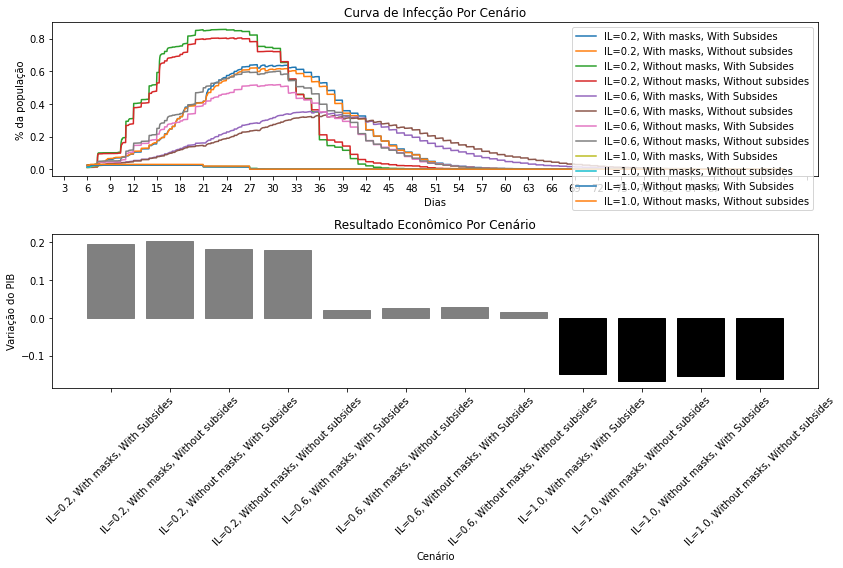

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[12, 8])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)

tick_unit=72

x = [i for i in range(0, 2160)]
ticks = []

pib = []
colors = []
for isolation in [.2, .6, 1.0]:
    for masks in [True, False]:
        for subsides in [True, False]:
          scenario = 'il{}_{}_{}'.format(isolation, 'mask' if masks else 'nomask',
                                                   'sub' if subsides else 'nosub')
          label = 'IL={}, {}, {}'.format(
              isolation, 
              'With masks' if masks else 'Without masks',
              'With Subsides' if subsides else 'Without subsides'
          )
          df = pd.read_csv('{}.csv'.format(scenario))
          df2 = df[(df['Metric'] == 'Infected')]
          ax[0].plot(x, df2['Avg'].values, label=str(label))
          df3 = df[(df['Metric'] == 'Business')]
          _start = df3['Avg'].values[0]
          _end = df3['Avg'].values[-1]
          res = _end - _start
          pib.append(res)
          colors.append('gray' if res > 0 else 'black')
          ticks.append(label)

#ax.set_title("Infection Curve by Isolation Level")
ax[0].set_ylabel("% da população")
ax[0].set_xlabel("Dias")
tickslabels = [str(i//24) for i in range(0, 2160, tick_unit)]
ax[0].xaxis.set_major_locator(MultipleLocator(tick_unit))
ax[0].set_xticklabels(tickslabels)
ax[0].set_title("Curva de Infecção Por Cenário")

bars = ax[1].bar([i for i in range(len(ticks))], pib)
ax[1].set_ylabel("Variação do PIB")
ax[1].set_xlabel("Cenário")
ax[1].set_title("Resultado Econômico Por Cenário")
ax[1].set_xticks([i for i in range(len(ticks))])
ax[1].set_xticklabels(ticks, rotation=45)

for ix, bar in enumerate(bars):
    bar.set_color(colors[ix])

handles, labels = ax[0].get_legend_handles_labels()
lgd = ax[0].legend(handles, labels, loc='top right')

plt.tight_layout()


# Decision Matrices by Scenario

## Common imports and codes

In [ ]:
from scipy.stats import norm
import itertools

def criteria_calculator(criteria, scenario, mu, sigma):
  return norm.ppf(scenarios[scenario][criteria_type[criteria]], loc=mu, scale=std)

## Types of criteria

In [ ]:
criteria_type = {
    'Infected': 'cost','Death': 'cost','Hospitalization': 'cost','Severe': 'cost',
    'People': 'benefit', 'Business': 'benefit', 'Government': 'benefit'
}

## Scenario definition

In [ ]:
scenarios = {
    'Pessimistic': { 'cost': .75, 'benefit': .25 },
    'Average': { 'cost': .5, 'benefit': .5 },
    'Optimistic': { 'cost': .25, 'benefit': .75 },
}

## Decision matrices generation

In [ ]:

metrics = None

rows = {}

ecom_metrics = ['People', 'Business', 'Government']
a1_metrics = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
epidem_metrics = ['Infected','Death','Hospitalization','Severe']
metrics = epidem_metrics + ecom_metrics

for isolation in [0.0, .2, .4, .6, .8, 1.0]:
    for masks in [True, False]:
        for subsides in [True, False]:
          scenario = 'il{}_{}_{}'.format(isolation, 'mask' if masks else 'nomask',
                                                   'sub' if subsides else 'nosub')
          df = pd.read_csv('{}.csv'.format(scenario))
          row = {}
          if metrics is None:
            metrics = df['Metric'].unique()
          for metric in epidem_metrics:
            mu = np.max(df[(df['Metric'] == metric)]['Avg'].values)
            row[metric+'_mu'] = mu
            row[metric+'_sigma'] = df[(df['Metric'] == metric) & (df['Avg'] == mu)]['Std'].values[0]
          for metric in ecom_metrics:
            if metric == 'People':
              start = 0
              end = 0
              _tmp = []
              for m2 in a1_metrics:
                start += df[(df['Metric'] == m2)]['Avg'].values[0]
                end += df[(df['Metric'] == m2)]['Avg'].values[-1]
                _tmp.append(df[(df['Metric'] == m2)]['Std'].values[-1]) 
              std = np.mean(_tmp)
            else:
              start = df[(df['Metric'] == metric)]['Avg'].values[0]
              end = df[(df['Metric'] == metric)]['Avg'].values[-1]
              std = df[(df['Metric'] == metric)]['Std'].values[-1]
            row[metric + '_mu'] = end - start
            row[metric + '_sigma'] = std

          for scenario in scenarios.keys():
            if scenario not in rows:
              rows[scenario] = []

            row2 = [isolation, masks, subsides]

            for metric in metrics:
              mu = row[metric + '_mu']
              sigma = row[metric + '_sigma']
              row2.append(criteria_calculator(metric, scenario, mu, sigma))
            rows[scenario].append(row2)


columns = ['IL','Masks','Subsides']
columns.extend(epidem_metrics)
columns.extend(ecom_metrics)

for scenario in scenarios.keys():
  df = pd.DataFrame(rows[scenario], columns=columns)
  df.to_csv('DM_{}.csv'.format(scenario))
  

## Visualization

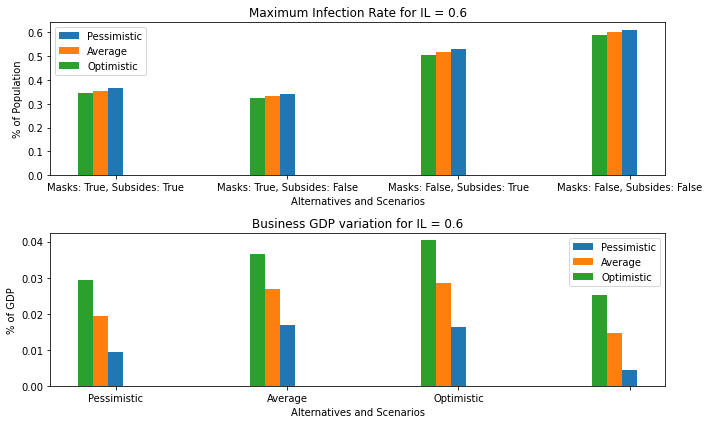

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[10, 6])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)

values1 = {}
values2 = {}
labels = []
wd = .35
for ct, scenario in enumerate(scenarios.keys()):
  df = pd.read_csv('DM_{}.csv'.format(scenario))
  if scenario not in values1:
    values1[scenario] = []
    values2[scenario] = []
  for masks in [True, False]:
    for subsides in [True, False]:
      if len(labels) < 4:
        labels.append('Masks: {}, Subsides: {}'.format(masks,subsides))
      df2 = df[(df['IL'] == 0.6) & (df['Masks'] == masks) & (df['Subsides'] == subsides)]
      values1[scenario].append(df2['Infected'].values[0])
      values2[scenario].append(df2['Business'].values[0])
  ax[0].bar(np.arange(4) - ct*wd/4, values1[scenario], wd/4, label=scenario)
  ax[1].bar(np.arange(4) - ct*wd/4, values2[scenario], wd/4, label=scenario)

ax[0].set_title("Maximum Infection Rate for IL = 0.6")
ax[0].set_xlabel("Alternatives and Scenarios")
ax[0].set_ylabel("% of Population")
ax[0].set_xticks(np.arange(4))
ax[0].set_xticklabels(labels.copy())#, rotation=45)
handles, labels = ax[0].get_legend_handles_labels()
lgd = ax[0].legend(handles, labels, loc='top right')

ax[1].set_title("Business GDP variation for IL = 0.6")
ax[1].set_xlabel("Alternatives and Scenarios")
ax[1].set_ylabel("% of GDP")
ax[1].set_xticks(np.arange(4))
ax[1].set_xticklabels(labels.copy())#, rotation=45)
handles, labels = ax[1].get_legend_handles_labels()
lgd = ax[1].legend(handles, labels, loc='top right')


plt.tight_layout()


In [ ]:

tick_unit=72

x = [i for i in range(0, 2160)]
ticks = []

pib = []
colors = []
for isolation in [.6]:
    for masks in [True, False]:
        for subsides in [True, False]:
          scenario = 'il{}_{}_{}'.format(isolation, 'mask' if masks else 'nomask',
                                                   'sub' if subsides else 'nosub')
          label = '{}, {}'.format(
              #isolation, 
              'With masks' if masks else 'Without masks',
              'With Subsides' if subsides else 'Without subsides'
          )
          df = pd.read_csv('{}.csv'.format(scenario))
          df2 = df[(df['Metric'] == 'Infected')]
          ax[0].plot(x, df2['Avg'].values, label=str(label))
          df3 = df[(df['Metric'] == 'Business')]
          _start = df3['Avg'].values[0]
          _end = df3['Avg'].values[-1]
          res = _end - _start
          pib.append(res)
          colors.append('gray' if res > 0 else 'black')
          ticks.append(label)

#ax.set_title("Infection Curve by Isolation Level")
ax[0].set_ylabel("% da população")
ax[0].set_xlabel("Dias")
tickslabels = [str(i//24) for i in range(0, 2160, tick_unit)]
ax[0].xaxis.set_major_locator(MultipleLocator(tick_unit))
ax[0].set_xticklabels(tickslabels)
ax[0].set_title("Curva de Infecção Por Cenário")

bars = ax[1].bar([i for i in range(len(ticks))], pib)
ax[1].set_ylabel("Variação do PIB")
ax[1].set_xlabel("Cenário")
ax[1].set_title("Resultado Econômico Por Cenário")
ax[1].set_xticks([i for i in range(len(ticks))])
ax[1].set_xticklabels(ticks, rotation=45)

for ix, bar in enumerate(bars):
    bar.set_color(colors[ix])

handles, labels = ax[0].get_legend_handles_labels()
lgd = ax[0].legend(handles, labels, loc='top right')

plt.tight_layout()


## Dataset

In [ ]:
# #Import csv proveniente do COVID-ABS
pop  = pd.read_csv('MatrizDecisao.csv', delimiter = ",", header=None)
pop = pop.to_numpy()

In [ ]:
pop.shape

(11, 7)

In [ ]:
pop = pop[:,0:6]
pop

array([[ 9.16271819e-01,  1.10956118e-01,  8.98181125e-02,
         5.89615203e-04, -1.41817492e-01,  1.65192871e-01],
       [ 8.85428571e-01,  1.09428571e-01,  8.49523810e-02,
         5.71428571e-04, -1.96017419e-01,  1.40170152e-01],
       [ 8.53142857e-01,  1.06285714e-01,  7.98095238e-02,
         8.57142857e-04, -2.04682970e-01,  1.40187366e-01],
       [ 8.25904762e-01,  1.02666667e-01,  7.50476190e-02,
         8.57142857e-04, -1.75191232e-01,  1.04487592e-01],
       [ 7.80190476e-01,  1.05142857e-01,  7.70476190e-02,
         6.66666667e-04, -1.63578276e-01,  8.27018822e-02],
       [ 7.36666667e-01,  9.32380952e-02,  6.68571429e-02,
         6.66666667e-04, -1.53132151e-01,  6.63988408e-02],
       [ 5.51047619e-01,  7.28571429e-02,  4.91428571e-02,
         1.61904762e-03, -1.22949452e-01,  3.13840462e-02],
       [ 4.26857143e-01,  6.17142857e-02,  3.84761905e-02,
         1.42857143e-03, -9.39206286e-02, -4.88448464e-03],
       [ 2.01047619e-01,  3.31428571e-02,  1.580

In [ ]:
# Gera a tabela para o Latex
df = pd.DataFrame(pop)
print(df.to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
        0 &         1 &         2 &         3 &         4 &         5 \\
\midrule
 0.916272 &  0.110956 &  0.089818 &  0.000590 & -0.141817 &  0.165193 \\
 0.885429 &  0.109429 &  0.084952 &  0.000571 & -0.196017 &  0.140170 \\
 0.853143 &  0.106286 &  0.079810 &  0.000857 & -0.204683 &  0.140187 \\
 0.825905 &  0.102667 &  0.075048 &  0.000857 & -0.175191 &  0.104488 \\
 0.780190 &  0.105143 &  0.077048 &  0.000667 & -0.163578 &  0.082702 \\
 0.736667 &  0.093238 &  0.066857 &  0.000667 & -0.153132 &  0.066399 \\
 0.551048 &  0.072857 &  0.049143 &  0.001619 & -0.122949 &  0.031384 \\
 0.426857 &  0.061714 &  0.038476 &  0.001429 & -0.093921 & -0.004884 \\
 0.201048 &  0.033143 &  0.015810 &  0.001429 & -0.080097 & -0.024124 \\
 0.066381 &  0.010952 &  0.005238 &  0.001143 & -0.057878 & -0.052935 \\
 0.045629 &  0.009952 &  0.008449 &  0.001099 & -0.059182 & -0.075627 \\
\bottomrule
\end{tabular}



# MCDM

## Criterios

In [ ]:
# C1: Infectados        CUSTO
# C2: Mortos            CUSTO
# C3: Hospitalizados    CUSTO
# C4: Severos           CUSTO
# C5: PIB Pessoas       BENEFÍCIO
# C6: PIB Empresas      BENEFÍCIO

weightsDM1 = [7, 3, 5, 3, 5, 3]     # pesos decisor 1
weightsDM2 = [10, 4, 8, 7, 8, 6]    # pesos decisor 2
print("Soma dos pesos: ", sum(weightsDM1))
print("Soma dos pesos: ", sum(weightsDM2))
cost_benefit = ['min', 'min', 'min', 'min', 'max', 'max']

Soma dos pesos:  26
Soma dos pesos:  43


### TOPSIS

In [ ]:
# Armazena numero de criterios e alternativas  
nrows, ncol = pop.shape
print("Numero alternativas: ", nrows)
print("Numero de criterios: ", ncol)

Numero alternativas:  11
Numero de criterios:  6


In [ ]:
# 1: Constrói NDM
rij = np.zeros(shape=(nrows,ncol))  
for i in range(nrows):
  for j in range(ncol):
    rij[i,j] = pop[i,j]/np.sqrt(np.sum((pop[:,j])**2)) 

print("rij: ", rij)

rij:  [[ 0.42185317  0.40167337  0.43860013  0.16846973 -0.30336777  0.52536951]
 [ 0.40765289  0.39614348  0.41483977  0.1632733  -0.41930912  0.44578876]
 [ 0.39278849  0.38476599  0.38972615  0.24490995 -0.43784597  0.4458435 ]
 [ 0.38024802  0.37166464  0.3664728   0.24490995 -0.37475895  0.33230608]
 [ 0.35920108  0.38062873  0.37623921  0.19048552 -0.34991718  0.26302011]
 [ 0.33916264  0.33753218  0.32647704  0.19048552 -0.32757144  0.2111709 ]
 [ 0.2537033   0.26375088  0.23997458  0.46260768 -0.26300635  0.09981194]
 [ 0.19652579  0.22341251  0.18788707  0.40818325 -0.20090957 -0.01553432]
 [ 0.09256268  0.11998079  0.07720112  0.40818325 -0.1713379  -0.07672402]
 [ 0.03056191  0.03964883  0.02557869  0.3265466  -0.12380832 -0.16835262]
 [ 0.02100776  0.03602871  0.04125866  0.31394724 -0.12659873 -0.24051998]]


In [ ]:
# Normaliza os pesos
weights = np.zeros(shape=(ncol))
weights_norm1 = [i/np.sum(weightsDM1) for i in weightsDM1]
weights_norm2 = [i/np.sum(weightsDM2) for i in weightsDM2]

for i in range(ncol):
  weights[i] = (weights_norm1[i]+weights_norm2[i])/2

print("Pesos normalizados DM1: ", weights_norm1)
print("Pesos normalizados DM2: ", weights_norm2)
print("Pesos: ", weights)
print("Soma dos pesos: ", sum(weights))

Pesos normalizados DM1:  [0.2692307692307692, 0.11538461538461539, 0.19230769230769232, 0.11538461538461539, 0.19230769230769232, 0.11538461538461539]
Pesos normalizados DM2:  [0.23255813953488372, 0.09302325581395349, 0.18604651162790697, 0.16279069767441862, 0.18604651162790697, 0.13953488372093023]
Pesos:  [0.25089445 0.10420394 0.1891771  0.13908766 0.1891771  0.12745975]
Soma dos pesos:  1.0


In [ ]:
# 2: Constrói WNDM
vij = np.zeros(shape=(nrows,ncol))
for i in range(nrows):
  for j in range(ncol):
    vij[i,j] = rij[i,j] * weights[j]
print(vij)

[[ 0.10584062  0.04185595  0.0829731   0.02343206 -0.05739024  0.06696347]
 [ 0.10227785  0.04127971  0.07847819  0.0227093  -0.07932368  0.05682012]
 [ 0.09854845  0.04009413  0.07372726  0.03406395 -0.08283043  0.0568271 ]
 [ 0.09540212  0.03872892  0.06932826  0.03406395 -0.07089581  0.04235565]
 [ 0.09012156  0.03966301  0.07117584  0.02649418 -0.06619632  0.03352448]
 [ 0.08509403  0.03517218  0.06176198  0.02649418 -0.06196902  0.02691579]
 [ 0.06365275  0.02748388  0.04539769  0.06434302 -0.04975478  0.012722  ]
 [ 0.04930723  0.02328046  0.03554393  0.05677325 -0.03800749 -0.00198   ]
 [ 0.02322346  0.01250247  0.01460468  0.05677325 -0.03241321 -0.00977922]
 [ 0.00766781  0.00413156  0.0048389   0.0454186  -0.0234217  -0.02145818]
 [ 0.00527073  0.00375433  0.00780519  0.04366619 -0.02394958 -0.03065662]]


In [ ]:
# 3: Determina PIS e NIS
PIS = np.zeros(shape=(ncol))
NIS = np.zeros(shape=(ncol))
for j in range(ncol):
  if cost_benefit[j] == 'max':
    PIS[j] = max(vij[:,j])
    NIS[j] = min(vij[:,j])
  elif cost_benefit[j] == 'min':
    PIS[j] = min(vij[:,j])
    NIS[j] = max(vij[:,j])
  else:
    print("Evaluation of ",j,"th criteria is missing")

print("PIS: ", PIS)
print("NIS: ", NIS)

PIS:  [ 0.00527073  0.00375433  0.0048389   0.0227093  -0.0234217   0.06696347]
NIS:  [ 0.10584062  0.04185595  0.0829731   0.06434302 -0.08283043 -0.03065662]


In [ ]:
# 4: Calcula medida de separação (L^2 norm)
SiplusDIF = np.zeros(shape=(nrows,ncol))
SiminusDIF = np.zeros(shape=(nrows,ncol))
for i in range(nrows):
  for j in range(ncol):
    SiplusDIF[i,j] = (vij[i,j] - PIS[j])**2
    SiminusDIF[i,j] = (vij[i,j] - NIS[j])**2

SiplusSUM = np.zeros(nrows)
SiminusSUM = np.zeros(nrows)
for i in range(nrows):
  SiplusSUM[i] = np.sum(SiplusDIF[i,:])
  SiminusSUM[i] = np.sum(SiminusDIF[i,:])

Siplus = np.sqrt(SiplusSUM)
Siminus = np.sqrt(SiminusSUM)

print("S+", Siplus)
print("S-", Siminus)

S+ [0.13720559 0.13953207 0.13611757 0.12842909 0.12590411 0.1170603
 0.10481174 0.09689985 0.08732034 0.09132354 0.09988968]
S- [0.10886042 0.09711371 0.09333803 0.0818228  0.07886389 0.07814935
 0.07983725 0.093163   0.12408273 0.14538956 0.14529534]


In [ ]:
# 5: Calcula CCi
Cj = np.zeros(shape=(nrows))
for i in range(nrows):
  Cj[i] = Siminus[i] / (Siplus[i] + Siminus[i])

print("CCi", Cj)

CCi [0.44240332 0.41037584 0.40678036 0.38916558 0.38513777 0.40033547
 0.43237308 0.49016943 0.58694858 0.61420159 0.59259468]


In [ ]:
# 6: Ranking das alternativas pelo Cj+
temp = (-Cj).argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(Cj))

ranking = np.zeros((len(Cj),3))
for i in range(len(ranks)):
  ranking[i,0] = i+1
  ranking[i,1] = np.abs(ranks[i])+1
  ranking[i,2] = Cj[i]

print("Ranking: \n", ranking)

Ranking: 
 [[ 1.          5.          0.44240332]
 [ 2.          7.          0.41037584]
 [ 3.          8.          0.40678036]
 [ 4.         10.          0.38916558]
 [ 5.         11.          0.38513777]
 [ 6.          9.          0.40033547]
 [ 7.          6.          0.43237308]
 [ 8.          4.          0.49016943]
 [ 9.          3.          0.58694858]
 [10.          1.          0.61420159]
 [11.          2.          0.59259468]]
